In [17]:
from boututils.datafile import DataFile
from boutdata.collect import collect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import platform
import traceback
import xarray as xr
import xbout
from pathlib import Path
import xhermes as xh

sys.path.append(os.path.join(r"/users/jlb647/scratch/simulation_program/hermes-3_sim/sdtool_load_test/sdtools"))
sys.path.append(os.path.join(r"/users/jlb647/scratch/simulation_program/hermes-3_sim/analysis/my_notebooks/notebooks/hermes-3/transients"))
sys.path.append(os.path.join(r"/users/jlb647/scratch/simulation_program/hermes-3_sim/analysis/my_notebooks/notebooks/hermes-3/general_functions"))


from plotting_functions import *
from convergence_functions import * 

from hermes3.case_db import *
from hermes3.casedeck import*
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
from hermes3.fluxes import *
from hermes3.selectors import *
from hermes3.front_tracking import *
# from hermes3.balance1d import *

# plt.style.use('ggplot')
plt.rcParams.update({'font.size': 10})
linewidth = 3
markersize = 15



# plt.style.use('ggplot')
plt.style.use('default')
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.grid'] = True
plt.rcParams.update({'font.size': 16})



%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
case_ds = xh.open('/users/jlb647/scratch/simulation_program/hermes-3_sim/simulation_dir/2025-01_STEP_1D-2D_comparison/03-01_production/sep_add_6/base/FCX_on/m7a-base_from_m6c_BASELINE1_1D_sep_add_6_tuned_density_fcx_on')

/mnt/scratch/users/jlb647/simulation_program/hermes-3_sim/analysis/hermes-3_venv/src/xbout/xbout/load.py:964: UserWarning: Ignoring 39 files as the first seems to be missing: [PosixPath('/users/jlb647/scratch/simulation_program/hermes-3_sim/simulation_dir/2025-01_STEP_1D-2D_comparison/03-01_production/sep_add_6/base/FCX_on/m7a-base_from_m6c_BASELINE1_1D_sep_add_6_tuned_density_fcx_on/BOUT.dmp.1.nc'), PosixPath('/users/jlb647/scratch/simulation_program/hermes-3_sim/simulation_dir/2025-01_STEP_1D-2D_comparison/03-01_production/sep_add_6/base/FCX_on/m7a-base_from_m6c_BASELINE1_1D_sep_add_6_tuned_density_fcx_on/BOUT.dmp.2.nc'), PosixPath('/users/jlb647/scratch/simulation_program/hermes-3_sim/simulation_dir/2025-01_STEP_1D-2D_comparison/03-01_production/sep_add_6/base/FCX_on/m7a-base_from_m6c_BASELINE1_1D_sep_add_6_tuned_density_fcx_on/BOUT.dmp.3.nc'), PosixPath('/users/jlb647/scratch/simulation_program/hermes-3_sim/simulation_dir/2025-01_STEP_1D-2D_comparison/03-01_production/sep_add_6/bas

In [3]:
case_ds = case_ds.hermes.extract_1d_tokamak_geometry()

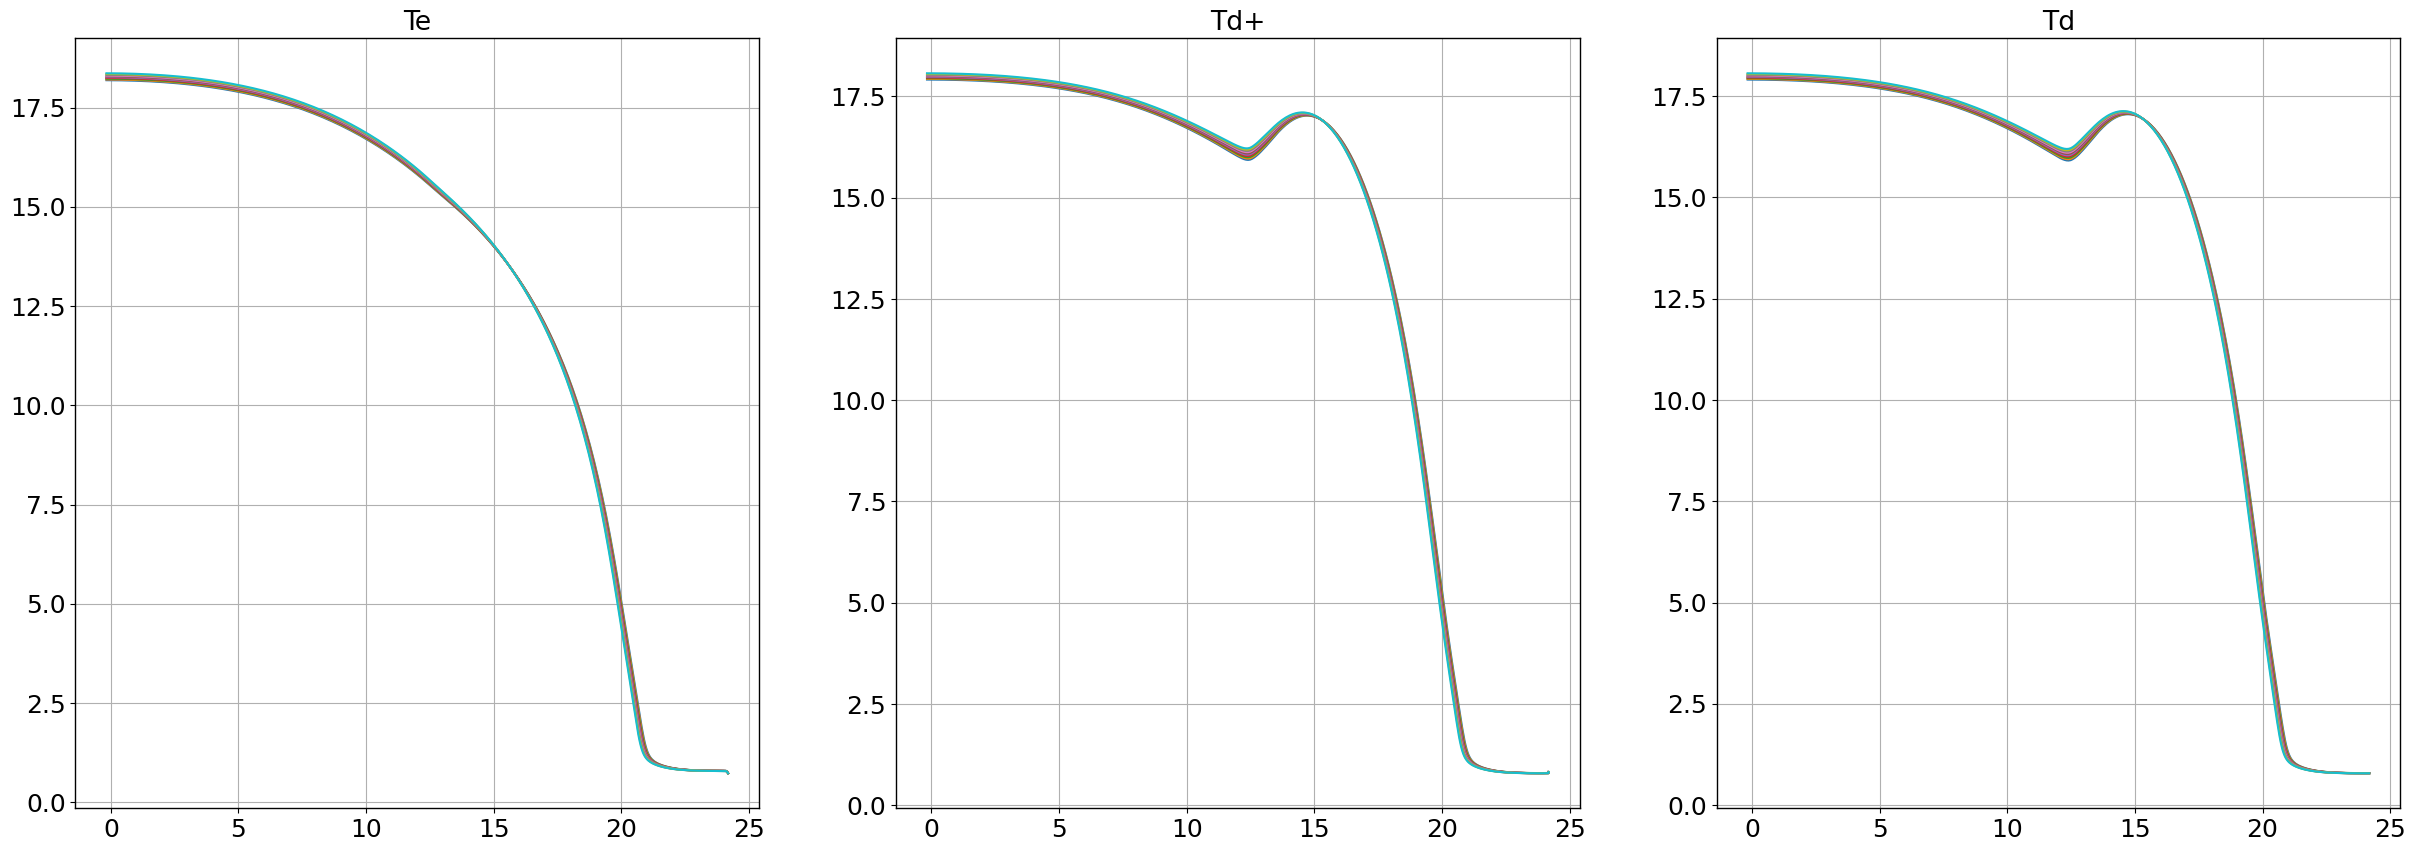

In [7]:
fig,ax = plt.subplots(1,3,figsize=(30,10))

ax= ax.flatten()

for t in range(0,10):

    case_t = case_ds.isel(t=t)
    ax[0].plot(case_t['pos'],case_t['Te'], label = f't = {t}')
    ax[1].plot(case_t['pos'],case_t['Td+'], label = f't = {t}')
    ax[2].plot(case_t['pos'],case_t['Td'], label = f't = {t}')

ax[0].set_title('Te')
ax[1].set_title('Td+')
ax[2].set_title('Td')
plt.show()



In [ ]:
def front_tracking(ds):

    df = pd.DataFrame()
    df.index = range(ds.dims["t"])
    dist = ds["pos"].values
    df["t"] = ds["t"]

    def find_crossing(dist, data, threshold):

        # Find indices where the temperature crosses the threshold
        final_crossing = np.where(np.diff(np.signbit(data - threshold)))[0][-1]

        # Initialize a list to store crossing times
        crossing_times = []

        # Interpolate within each crossing interval to find the exact crossing time
        t1, t2 = dist[final_crossing], dist[final_crossing + 1]
        data1, data2 = data[final_crossing], data[final_crossing + 1]

        # Linear interpolation to find the crossing time
        location = t1 + (threshold - data1) * (t2 - t1) / (data2 - data1)

        return location
    

    for t in range(ds.dims["t"]):

        timeslice = ds.isel(t=t)
        df.loc[t, "5eV"] = find_crossing(dist, timeslice["Te"].values, 5)

    
    for col in df:
        if col != "t":
            df[col] = dist[-1] - df[col]

    ds["front_poldist_5eV"] = xr.DataArray(df["5eV"].values, dims = ["t"])
    ds["front_poldist_5eV"].attrs.update(dict(
        short_name = "5eV front pol. distance from target [m]",
        units = "m",
        origin = "sdtools")
    )

    return ds


case_ds = front_tracking(case_ds)


ValueError: cannot reindex or align along dimension 't' because the (pandas) index has duplicate values

In [ ]:

df = pd.DataFrame()
df.index = range(ds.dims["t"])
dist = ds["pos"].values
df["t"] = ds["t"]

def find_crossing(dist, data, threshold):

    # Find indices where the temperature crosses the threshold
    final_crossing = np.where(np.diff(np.signbit(data - threshold)))[0][-1]

    # Initialize a list to store crossing times
    crossing_times = []

    # Interpolate within each crossing interval to find the exact crossing time
    t1, t2 = dist[final_crossing], dist[final_crossing + 1]
    data1, data2 = data[final_crossing], data[final_crossing + 1]

    # Linear interpolation to find the crossing time
    location = t1 + (threshold - data1) * (t2 - t1) / (data2 - data1)

    return location



